## Прогноз количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install optuna -q
!pip install shutup -q

In [2]:
from copy import deepcopy
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
import optuna
from datetime import datetime
from io import BytesIO
from lightgbm import LGBMRegressor
import lightgbm as lgb

%matplotlib inline
import matplotlib.pyplot as plt
from optuna.samplers import TPESampler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import requests
import time
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet,
    BayesianRidge,
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn import preprocessing
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.model_selection import TimeSeriesSplit
import shutup

In [3]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
pd.options.display.float_format = (
    "{:,.3f}".format
)  # отображение количества знаков после запятой
optuna.logging.set_verbosity(optuna.logging.WARNING)
shutup.please()

In [4]:
try:
    df = pd.read_csv(
        "/datasets/taxi.csv", index_col=[0], parse_dates=[0]
    )  # если нет интернета
except:
    print("ошибка чтения с диска")
try:
    df.shape  # проверка на существование датасета
except:
    try:
        df = pd.read_csv(
            "https://code.s3.yandex.net/datasets/taxi.csv",
            index_col=[0],
            parse_dates=[0],
        )  # если нет интернета
    except:
        print("ошибка связи с сетью")
        try:  # если ЯП удалит файл у себя
            spreadsheet_id = "1e-5P0ubndFCQ6ax_U6pgecnV9rLjrouUUqgBjrAgKHw"
            file_name = (
                "https://docs.google.com/spreadsheets/d/{}/export?format=csv".format(
                    spreadsheet_id
                )
            )
            r = requests.get(file_name)
            df = pd.read_csv(BytesIO(r.content))
        except:
            pass

df_raw = df.copy()  # сохраним нетронутые сеты на всякий случай
start_time_project = time.time()

ошибка чтения с диска


## Подготовка данных

### Первичное ознакомление

Получим общую информацию о таблицах:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Что ж, пропусков нет. И то хорошо.

Выведем на экран первые пять строк таблицы:

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


На руках у нас количество заказов такси за последние 10 минут. Ресемплируем данные, чтобы посмотреть количество заказов за 1 час:

In [7]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.resample("1H").sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


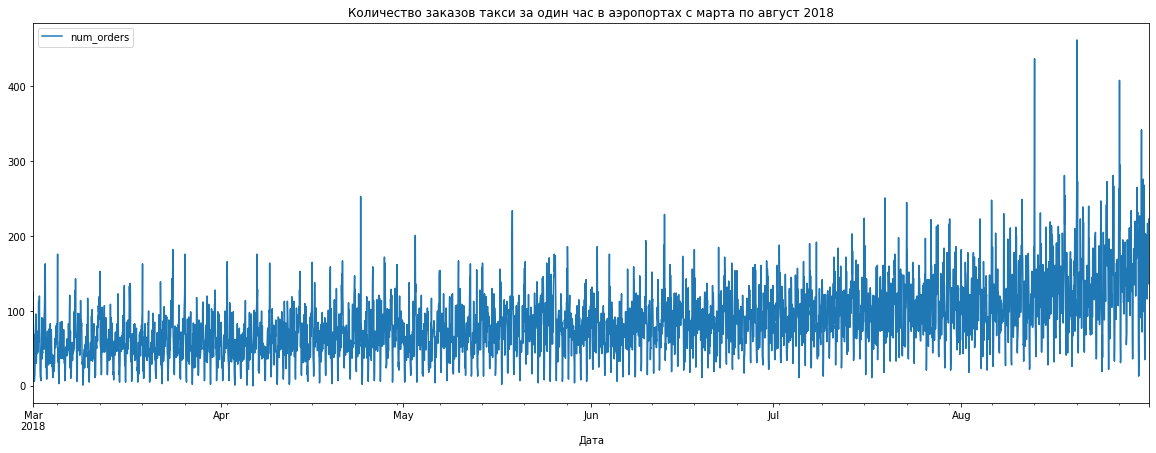

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
df.plot(ax=ax)
plt.title("Количество заказов такси за один час в аэропортах с марта по август 2018")
plt.xlabel("Дата")
plt.show()

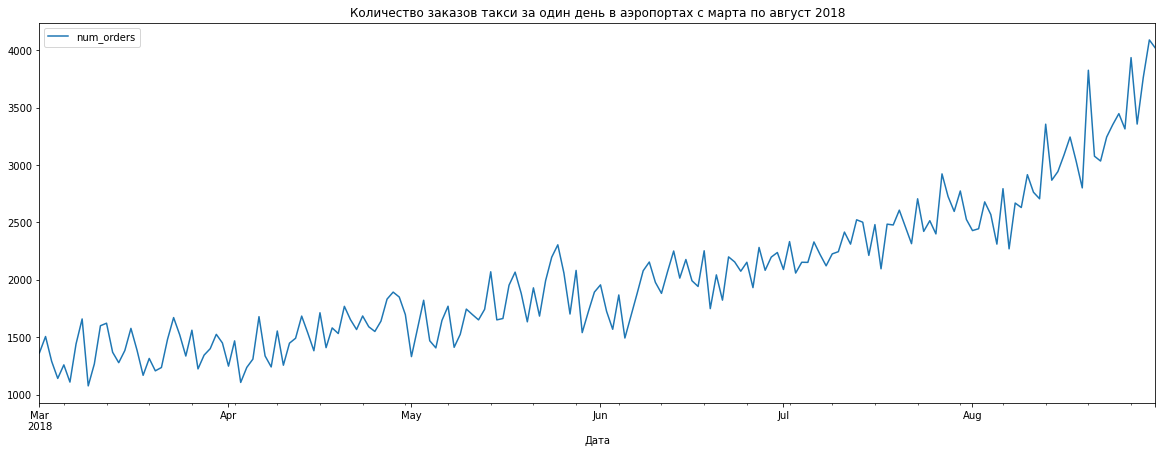

In [10]:
dfd = df.resample("1D").sum()
fig, ax = plt.subplots(figsize=(20, 7))
dfd.plot(ax=ax)
plt.title("Количество заказов такси за один день в аэропортах с марта по август 2018")
plt.xlabel("Дата")
plt.show()

Наш временной ряд имеет явно не стационарный характер.

### Изучение распределений

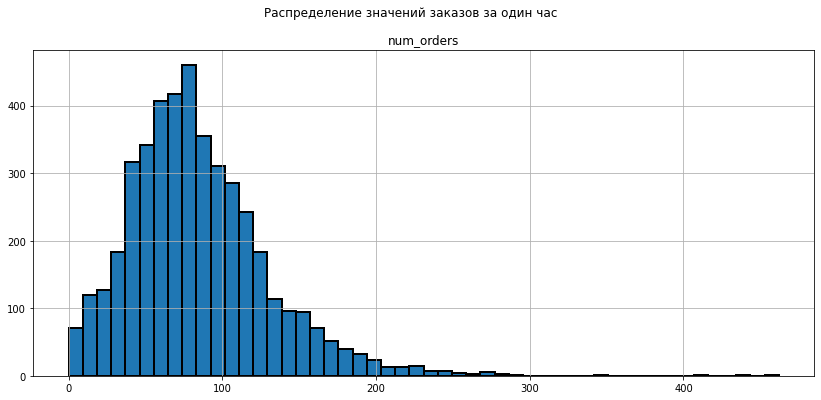

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))
df.hist(bins=50, edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений заказов за один час")
plt.show()

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,"4,416.000",84.423,45.024,0.000,54.000,78.000,107.000,462.000


In [13]:
df["date"] = df.index
df["date"].describe(datetime_is_numeric=True)

count                   4416
mean     2018-05-31 23:30:00
min      2018-03-01 00:00:00
25%      2018-04-15 23:45:00
50%      2018-05-31 23:30:00
75%      2018-07-16 23:15:00
max      2018-08-31 23:00:00
Name: date, dtype: object

Мы имеем данные с 1 марта по 31 августа включительно.

Проверим, нет ли разрывов времени в наших данных:

In [14]:
df["date"] = df.index
df["over_1h"] = (df["date"].diff()).dt.seconds > 3600
print(df["over_1h"].sum())
del df["over_1h"]

0


Разрывов во времени нет.

### Проверка явных дубликатов

Проверим, есть ли дубликаты в данных:

In [15]:
print(df.duplicated().sum())

0


Дубликаты не обнаружены

### Создание новых признаков

Добавим признак сезонности в наш датасет.

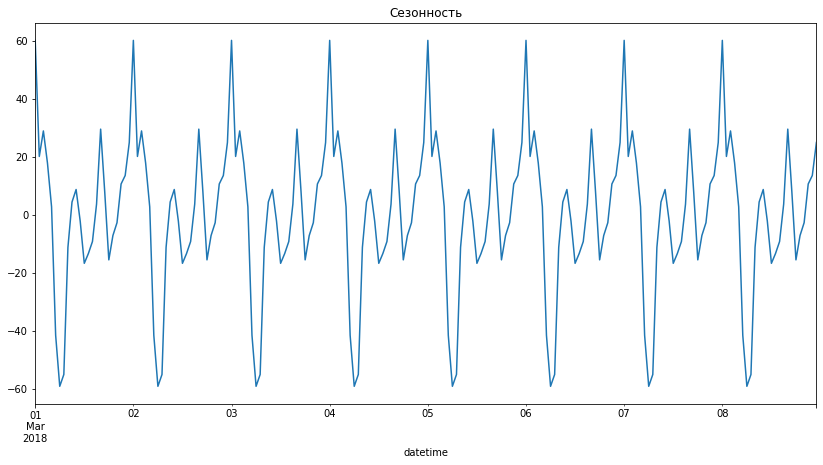

In [16]:
decomposed = seasonal_decompose(df["num_orders"])
plt.figure(figsize=(14, 7))

decomposed.seasonal["2018-03":"2018-03-08"].plot(ax=plt.gca())
plt.title("Сезонность")
plt.show()

На графике видно, что один и тот же паттерн в количестве заказов повторяется изо дня в день.

Добавим и другие признаки.

In [17]:
df["seasonality"] = decomposed.seasonal.shift(1)
df["month"] = df.index.month
df["day"] = df.index.day
df["dayofweek"] = df.index.dayofweek
df["weekday_hour"] = df["dayofweek"].astype(str) + df.index.hour.astype(str)
# считаем разность между значением час назад и значением которое было два часа назад
df["diffs"] = df["num_orders"].shift(1) - df["num_orders"].shift(2)

Добавим выходные:

In [18]:
df["weekend"] = ((df["dayofweek"] == 5) | (df["dayofweek"] == 6)) * 1

In [19]:
del df["date"]  # удалим созданный столбец

## Обучение моделей

### Объявляем переменные

In [20]:
n = 4  # количество выборок при к-в -1
rstate = 12345  # фиксируем значение псевдослучайности
trials = 25  # число итерации при оптимизации optuna
sampler = TPESampler(seed=10)  # фиксируем генератор пвсевдослучайности для optuna
trgt = "num_orders"  #   название столбца-таргета

Создадим список, где явно обозначим для моделей, какие столбцы являются категориальными признаками:

In [21]:
cat_features = ["day", "dayofweek", "month", "weekday_hour"]

Добавим функцию просчета метрики sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»):

In [22]:
def smape(y_true, y_pred):
    y_true_s = np.array(y_true) +1e-30
    y_pred_s = np.array(y_pred) +1e-30
    y_true_s = y_true_s.reshape(-1,1) 
    y_pred_s = y_pred_s.reshape(-1,1)       # делаю решейп, так как какие-то модели могут выдавать не тот формат данных, что нужно
    smape = sum(abs(y_true_s - y_pred_s) / ((abs(y_true_s) + abs(y_pred_s))/2) )*100 / len(y_true_s)
    return abs(smape)[0]

### Сравнение моделей

Так как наш временной ряд не такой уж и стационарный, исключим из нашего исследования модели связанные с деревьями. Будем использовать только линейные модели, которые лучше всего подходят для таких задач с экстраполяцией.

Создадим таблицу, куда будем сохранять наши результаты:

In [23]:
df_report = pd.DataFrame(columns={"model"}, data=[0])
df_report["model"] = "bayesian_ridge"
df_report = df_report.set_index("model")

И создадим функцию для занесения результатов кросс-валидации в таблицу:

In [24]:
def table_results(X, y, model, modelname):
    rmse = []
    mae = []
    smapes = []
    r2 = []
    n = 6
    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]
        start = time.time()
        model_ = deepcopy(model)
        model_.fit(X_trainCV, y_trainCV)
        end = time.time()
        fit_time = end - start
        start = time.time()
        preds = model_.predict(X_testCV)
        end = time.time()
        pred_time = end - start
        rmse.append(mean_squared_error(y_testCV, preds, squared=False))
        mae.append(mean_absolute_error(y_testCV, preds))
        smapes.append(smape(y_testCV, preds))
        r2.append(r2_score(y_testCV, preds))

    df_report.loc[modelname, "rmse"] = round(np.mean(rmse), 2)
    df_report.loc[modelname, "mae"] = round(np.mean(mae), 2)
    df_report.loc[modelname, "smape"] = round(np.mean(smapes), 2)
    df_report.loc[modelname, "r2"] = round(np.mean(r2), 2)
    df_report.loc[modelname, "fit_time"] = fit_time
    df_report.loc[modelname, "pred_time"] = pred_time
    return df_report

Также создадим функцию для создания новых признаков. Для каждой модели будет свой набор признаков, на которых она будет обучаться.

In [25]:
def make_features(
    data,
    mkft_max_lag,
    mkft_max_lag24,
    mkft_rolling_mean_size,
    mkft_rolling_mean_size2,
    mkft_rolling_mean_size3,
    mkft_labeled=True,
    mkft_categorized=True,
):  # функция добавления фич

    for lag in range(1, mkft_max_lag + 1):
        data["lag_{}".format(lag)] = data[trgt].shift(
            lag
        )  # создаем сдвиги  с интервалом в час
    for lag in range(1, mkft_max_lag24 + 1):
        data["lag24_{}".format(lag)] = data[trgt].shift(
            lag * 24
        )  # создаем сдвиги с интервалом в день
    data["rolling_mean"] = (
        data[trgt].shift().rolling(mkft_rolling_mean_size).mean()
    )  # обычная MA
    data["rolling_mean2"] = (
        data[trgt].shift().rolling(mkft_rolling_mean_size2).mean()
    )  # чуть больше MA
    data["diff_p_m"] = (
        data[trgt].shift() - data["rolling_mean2"]
    )  # разница между текущим значением и MA
    data["diff_m_m"] = (
        data["rolling_mean"] - data["rolling_mean2"]
    )  # разница между скользящими
    data["rolling_mean3"] = (
        data["diff_p_m"].rolling(mkft_rolling_mean_size).mean()
    )  # MA на разнице между текущим значением и MA
    data["mean"] = (
        data["diffs"].rolling(mkft_rolling_mean_size3).mean()
    )  # MA на разнице между текущим значением и предыдущим
    data["std"] = (
        data["diffs"].rolling(mkft_rolling_mean_size3).std()
    )  # разброс разброса
    data = data.dropna()
    features = data.drop([trgt], axis=1).copy()
    target = data[trgt].copy()
    if mkft_labeled:
        le = preprocessing.LabelEncoder()
        features[cat_features] = features[cat_features].apply(le.fit_transform)
    if mkft_categorized:
        for c in cat_features:
            try:
                features[c] = features[c].astype("category")
            except:
                pass
    return features, target

#### Bayesian Ridge

Итак, для всех моделей одинаковый пайплайн: находим через Optuna оптимальные параметры датасета и модели одновременно, применяем настройки к модели и датасету, помещаем модель в кросс-валидацию, считаем метрики, заносим в таблицу.

Создадим функцию, где укажем какие параметры будем оптимизировать через библиотеку Optuna и зададим rmse как целевой показатель.

In [26]:
def objective(trial, df, trgt="num_orders"):
    param_grid = {
        # "alpha": trial.suggest_float("alpha", 0, 1),
        "n_iter": trial.suggest_int("n_iter", 1, 800),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
        "mkft_labeled": trial.suggest_categorical("mkft_labeled", [True, False]),
        "mkft_categorized": trial.suggest_categorical(
            "mkft_categorized", [True, False]
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = BayesianRidge(**param_grid)
        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

Подадим функцию в оптимизатор и получим наилучшие параметры модели путем нахождения наименьшего показателя rmse на кросс-валидации.

In [27]:
study = optuna.create_study(
    direction="minimize", study_name="BayesianRidge", sampler=sampler
)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=75, show_progress_bar=True)

  0%|          | 0/75 [00:00<?, ?it/s]

In [28]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 22.05860

Лучшие параметры:
n_iter: 758
mkft_max_lag: 25
mkft_max_lag24: 14
mkft_rolling_mean_size: 2
mkft_rolling_mean_size2: 200
mkft_rolling_mean_size3: 220
mkft_labeled: False
mkft_categorized: False


In [29]:
def_params_bridge = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_bridge = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

Повторно закидываем модель в обучение через к-в, чтобы посчитать все метрики:

In [30]:
data = df.copy()
features, target = make_features(data, **def_params_bridge)

X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

bridge_optuna = BayesianRidge(**model_params_bridge)
model = bridge_optuna
df_report = table_results(X_train, y_train, model, "bayesian_ridge")
df_report

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009


#### Ridge

Делаем все то же самое что и с предыдущей моделью.

In [31]:
def objective(
    trial,
    df,
    trgt="num_orders",
):
    param_grid = {
        "alpha": trial.suggest_float("alpha", 0.01, 1),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
        "mkft_labeled": trial.suggest_categorical("mkft_labeled", [True, False]),
        "mkft_categorized": trial.suggest_categorical(
            "mkft_categorized", [True, False]
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = Ridge(
            **param_grid,
            random_state=rstate,
        )
        model.fit(
            X_trainCV,
            y_trainCV,
        )
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

In [32]:
study = optuna.create_study(direction="minimize", study_name="Ridge", sampler=sampler)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 22.25948

Лучшие параметры:
alpha: 0.4406998789153239
mkft_max_lag: 7
mkft_max_lag24: 22
mkft_rolling_mean_size: 16
mkft_rolling_mean_size2: 200
mkft_rolling_mean_size3: 11
mkft_labeled: True
mkft_categorized: False


In [34]:
def_params_ridge = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_ridge = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

In [35]:
data = df.copy()
features, target = make_features(data, **def_params_ridge)


X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

ridge_optuna = Ridge(random_state=rstate, **model_params_ridge)
model = ridge_optuna
df_report = table_results(X_train, y_train, model, "ridge")
df_report.sort_values(by="rmse")

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009
ridge,22.380,16.780,22.190,0.610,0.003,0.002


#### Elastic Net

Делаем все то же самое что и с предыдущей моделью.

In [36]:
def objective(trial, df, trgt="num_orders"):
    param_grid = {
        "alpha": trial.suggest_float("alpha", 0, 1),
        "l1_ratio": trial.suggest_float("l1_ratio", 0, 1),
        "max_iter": trial.suggest_int("max_iter", 1, 1500),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
        "mkft_labeled": trial.suggest_categorical("mkft_labeled", [True, False]),
        "mkft_categorized": trial.suggest_categorical(
            "mkft_categorized", [True, False]
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = ElasticNet(
            **param_grid,
            random_state=rstate,
        )
        model.fit(
            X_trainCV,
            y_trainCV,
        )
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

In [37]:
study = optuna.create_study(
    direction="minimize", study_name="ElasticNet", sampler=sampler
)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=120, show_progress_bar=True)

  0%|          | 0/120 [00:00<?, ?it/s]

In [38]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 22.17933

Лучшие параметры:
alpha: 0.497424885663163
l1_ratio: 0.8007813147909082
max_iter: 1187
mkft_max_lag: 27
mkft_max_lag24: 8
mkft_rolling_mean_size: 5
mkft_rolling_mean_size2: 50
mkft_rolling_mean_size3: 200
mkft_labeled: False
mkft_categorized: True


In [39]:
def_params_en = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_en = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

In [40]:
data = df.copy()
features, target = make_features(data, **def_params_en)

X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

en_optuna = ElasticNet(random_state=rstate, **model_params_en)

In [41]:
model = en_optuna
df_report = table_results(X_train, y_train, model, "elastic_net")
df_report

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009
ridge,22.380,16.780,22.190,0.610,0.003,0.002
elastic_net,21.920,16.570,22.630,0.610,0.099,0.005


#### Lasso

Делаем все то же самое что и с предыдущей моделью.

In [42]:
def objective(trial, df, trgt="num_orders"):
    param_grid = {
        "alpha": trial.suggest_float("alpha", 0, 3),
        # "l1_ratio": trial.suggest_float("l1_ratio", 0, 1),
        "max_iter": trial.suggest_int("max_iter", 1, 1500),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
        "mkft_labeled": trial.suggest_categorical("mkft_labeled", [True, False]),
        "mkft_categorized": trial.suggest_categorical(
            "mkft_categorized", [True, False]
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = Lasso(
            **param_grid,
            random_state=rstate,
        )
        model.fit(
            X_trainCV,
            y_trainCV,
        )
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

In [43]:
study = optuna.create_study(
    direction="minimize", study_name="Lasso", sampler=sampler
)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [44]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 22.04818

Лучшие параметры:
alpha: 2.6271071790927105
max_iter: 1397
mkft_max_lag: 23
mkft_max_lag24: 14
mkft_rolling_mean_size: 24
mkft_rolling_mean_size2: 200
mkft_rolling_mean_size3: 66
mkft_labeled: False
mkft_categorized: True


In [45]:
def_params_lasso = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_lasso = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

In [46]:
data = df.copy()
features, target = make_features(data, **def_params_lasso)

X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

lasso_optuna = Lasso(random_state=rstate, **model_params_lasso)

In [47]:
model = lasso_optuna
df_report = table_results(X_train, y_train, model, "lasso")
df_report.sort_values(by="rmse")

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009
lasso,21.740,16.400,21.740,0.630,0.035,0.005
elastic_net,21.920,16.570,22.630,0.610,0.099,0.005
ridge,22.380,16.780,22.190,0.610,0.003,0.002


#### Linear Regression

Делаем все то же самое что и с предыдущей моделью.

In [48]:
def objective(
    trial,
    df,
    trgt="num_orders",
):
    param_grid = {
        # "normalize": trial.suggest_categorical("normalize", [True, False]),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
        "mkft_labeled": trial.suggest_categorical("mkft_labeled", [True, False]),
        "mkft_categorized": trial.suggest_categorical(
            "mkft_categorized", [True, False]
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = LinearRegression(**param_grid)
        model.fit(
            X_trainCV,
            y_trainCV,
        )
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

In [49]:
study = optuna.create_study(direction="minimize", study_name="LR", sampler=sampler)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 22.21384

Лучшие параметры:
mkft_max_lag: 24
mkft_max_lag24: 15
mkft_rolling_mean_size: 28
mkft_rolling_mean_size2: 200
mkft_rolling_mean_size3: 30
mkft_labeled: True
mkft_categorized: True


In [51]:
def_params_lr = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_lr = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

In [52]:
data = df.copy()
features, target = make_features(data, **def_params_lr)

X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

lr_optuna = LinearRegression(**model_params_lr)

In [53]:
model = lr_optuna
df_report = table_results(X_train, y_train, model, "linear_regression")
df_report.sort_values(by="rmse")

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009
lasso,21.740,16.400,21.740,0.630,0.035,0.005
elastic_net,21.920,16.570,22.630,0.610,0.099,0.005
linear_regression,22.010,16.540,22.090,0.620,0.008,0.002
ridge,22.380,16.780,22.190,0.610,0.003,0.002


#### Bayesian_ridge + Boosting

Возьмем лучшее из двух миров : линейных моделей и градиентного бустинга.
Фишка в том, что линейная модель будет предсказывать тренд, а градиентный бустинг будет помогать предсказывать остатки от вычитания истинных значений и предсказаний линейной модели.

Остатки будут в относительных значениях, так как абсолютные могут сильно меняться со временем.

In [54]:
class BridgeBoosting:
    def __init__(self, learning_rate, num_leaves, max_depth, min_child_samples):
        self.learning_rate = learning_rate
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.min_child_samples = min_child_samples
        model1 = BayesianRidge(**model_params_bridge)
        self.model1_ = model1
        model2 = LGBMRegressor(
            learning_rate=self.learning_rate,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            min_child_samples=self.min_child_samples,
            n_estimators=1000,
            random_seed=rstate, 
        )
        self.model2_ = model2

    def fit(self, X_train, y_train):
        self.model1_.fit(X_train, y_train)
        y_hat1 = self.model1_.predict(X_train)
        residuals = y_train / y_hat1

        X_train, X_test, y_train, y_test = train_test_split(
            X_train, residuals, test_size=0.2, shuffle=False
        )
        self.model2_.fit(
            X_train,
            y_train,
            # categorical_feature=cat_features,
            eval_set=[(X_test, y_test)],
#             callbacks=[stopping_rounds=30],
            early_stopping_rounds=30,
            verbose=False,
        )

    def predict(self, X):
        hat1 = self.model1_.predict(X)
        hat2 = self.model2_.predict(X)
        return hat1 * hat2

In [55]:
def objective(trial, df, trgt="num_orders"):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 4, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 13),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
    }
    params = {
        "mkft_max_lag": trial.suggest_int("mkft_max_lag", 1, 31),
        "mkft_max_lag24": trial.suggest_int("mkft_max_lag24", 1, 31),
        "mkft_rolling_mean_size": trial.suggest_int("mkft_rolling_mean_size", 2, 31),
        "mkft_rolling_mean_size2": trial.suggest_int(
            "mkft_rolling_mean_size2", 50, 250, step=50
        ),
        "mkft_rolling_mean_size3": trial.suggest_int(
            "mkft_rolling_mean_size3", 5, 250, step=1
        ),
    }
    data = df.copy()
    features, target = make_features(data, **params)

    X_train, X_res, y_train, y_res = train_test_split(
        features, target, test_size=0.1, shuffle=False
    )
    X = X_train
    y = y_train

    cv_predicts = []
    cv = TimeSeriesSplit(n_splits=n)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_trainCV, X_testCV = X.iloc[train_idx], X.iloc[test_idx]
        y_trainCV, y_testCV = y.iloc[train_idx], y.iloc[test_idx]

        model = BridgeBoosting(**param_grid)
        model.fit(
            X_trainCV,
            y_trainCV,
        )
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

In [56]:
study = optuna.create_study(
    direction="minimize", study_name="b_ridge_boosting", sampler=sampler
)
func = lambda trial: objective(trial, df)
study.optimize(func, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [57]:
print(f"Лучший показатель rmse при кросс-валидации: {study.best_value:.5f}")
print("")
print(f"Лучшие параметры:")

for key, value in study.best_params.items():
    print(f"{key}: {value}")
    best_tresh = value

Лучший показатель rmse при кросс-валидации: 21.85198

Лучшие параметры:
learning_rate: 0.01756800956408352
num_leaves: 4
max_depth: 13
min_child_samples: 33
mkft_max_lag: 11
mkft_max_lag24: 7
mkft_rolling_mean_size: 25
mkft_rolling_mean_size2: 50
mkft_rolling_mean_size3: 123


In [58]:
def_params_bb = {
    k: v for k, v in study.best_params.items() if "mkft_" in str(k)
}  # отбираем настройки для функции создания фич
model_params_bb = {
    k: v for k, v in study.best_params.items() if "mkft_" not in str(k)
}  # отбираем настройки для самой модели

In [59]:
data = df.copy()
features, target = make_features(data, **def_params_bb)

X_train, X_res, y_train, y_res = train_test_split(
    features, target, train_size=0.9, shuffle=False
)

bb_optuna = BridgeBoosting(**model_params_bb)

In [60]:
model = bb_optuna
df_report = table_results(X_train, y_train, model, "b_ridge_boosting")
df_report.sort_values(by="rmse")

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
b_ridge_boosting,21.670,16.220,21.960,0.620,0.185,0.010
bayesian_ridge,21.710,16.380,21.710,0.630,0.055,0.009
lasso,21.740,16.400,21.740,0.630,0.035,0.005
elastic_net,21.920,16.570,22.630,0.610,0.099,0.005
linear_regression,22.010,16.540,22.090,0.620,0.008,0.002
ridge,22.380,16.780,22.190,0.610,0.003,0.002


## Анализ результатов моделей

Лучшей по показателю rmse стала гибридная модель. Её и будем проверять на тестовой выборке.

## Тестирование

Делаем предсказания, считаем метрики, заносим результаты.

In [61]:
df_report_f = pd.DataFrame(columns={"model"}, data=[0])
s = "b_ridge_boosting"
df_report_f["model"] = s
df_report_f = df_report_f.set_index("model")

data = df.copy()
features, target = make_features(data, **def_params_bb)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, shuffle=False
)
bb_optuna = BridgeBoosting(**model_params_bb)

In [62]:
start = time.time()
bb_optuna.fit(X_test, y_test)
end = time.time()
fit_time = end - start

In [63]:
model = bb_optuna
start = time.time()
preds = model.predict(X_test)
end = time.time()
pred_time = end - start

df_report_f.loc[s, "rmse"] = mean_squared_error(y_test, preds, squared=False)
df_report_f.loc[s, "mae"] = mean_absolute_error(y_test, preds)
df_report_f.loc[s, "smape"] = smape(y_test, preds)
df_report_f.loc[s, "r2"] = r2_score(y_test, preds)
df_report_f.loc[s, "fit_time"] = fit_time
df_report_f.loc[s, "pred_time"] = pred_time
df_report_f.sort_values(by="rmse")

,rmse,mae,smape,r2,fit_time,pred_time
model,,,,,,
b_ridge_boosting,28.185,20.754,16.013,0.771,0.168,0.043


Результат хорош. Метрика rmse и mae выше чем на кросс-валидации. Но оно и понятно, так как средние объемы заказа в абсолютных величинах выше на тестовой выборке. Адекватней всего сравнить как изменились smape и r2 - здесь они даже еще лучше чем на кросс-валидации.

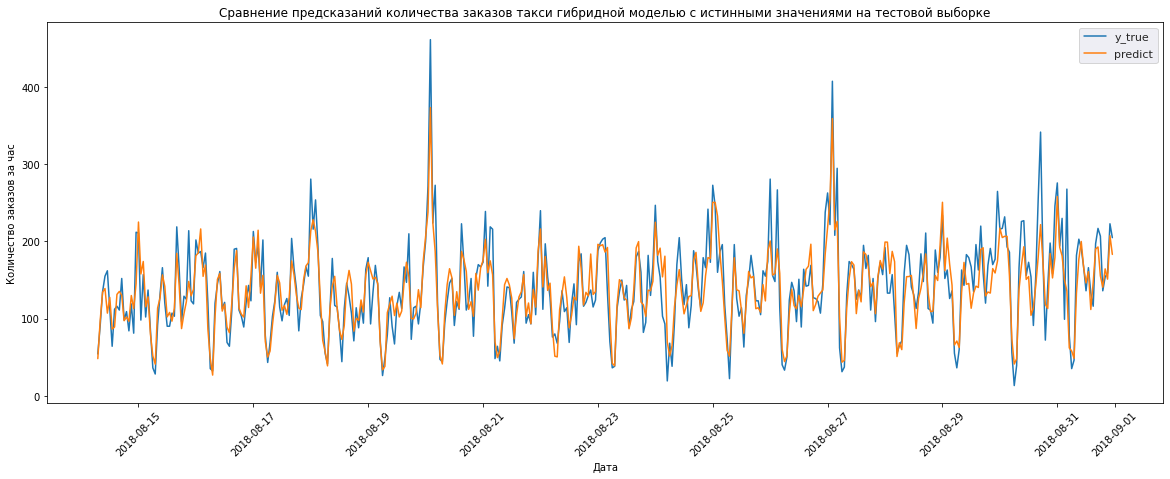

In [64]:
fig, ax = plt.subplots(figsize=(20, 7))
p = pd.Series(preds, index=y_test.index)
sns.set()
sns.lineplot(data=y_test, label="y_true")
sns.lineplot(data=p, label="predict")
plt.legend()
plt.title(
    'Сравнение предсказаний количества заказов такси гибридной моделью с истинными значениями на тестовой выборке'
)
plt.xticks(rotation=45)
plt.ylabel("Количество заказов за час")
plt.xlabel("Дата")
plt.show()

## Вывод

Задача требовала спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Имеющиеся данные обработали. Для решения данного типа задачи было решено пользоваться только линейными моделями машинного обучения. Для каждой такой модели мы подбирали наилучшие параметры и создавали свои признаки, на которых она будет обучаться.

По итогу, лучшая модель лидирующая по основной метрике была выбрана для проверки на тестовой выборке. 

Результаты на тестовой выборке этой модели не сильно отличаются от того, что мы получили на кросс-валидации, что говорит о надежности модели.

In [65]:
end_time_project = time.time()
time_of_proj = end_time_project - start_time_project
time_of_proj
print(f"Время выполнения проекта: {time_of_proj/60:.1f} минут")

Время выполнения проекта: 5.2 минут
